In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import seaborn as sns
import xgboost as xgb
import pickle
import matplotlib.pyplot as plt

from util import ScoreDistribution, ROC_AUC, \
    prob_scale, get_resampling, PSI, xgbCV

In [2]:
df_treino = pd.read_csv('../dataset/cs-training.csv')
df_treino.drop(columns='Unnamed: 0', inplace=True)
df_treino.rename(columns={'SeriousDlqin2yrs':'target'})
df_treino.rename(columns={'SeriousDlqin2yrs':'target'}, inplace=True)
df_treino.target = df_treino.target.apply(lambda target: 1 if target==0 else 0)
df_treino
print(df_treino.dtypes)

target                                    int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object


In [3]:
df_treino.target.value_counts(normalize=True)

1    0.93316
0    0.06684
Name: target, dtype: float64

In [4]:
df_treino.head()

,target,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,1,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,1,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,1,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,1,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
df_treino.shape

(150000, 11)

# Preparação de dados

In [6]:
df_treino['MonthlyIncome'] = np.log(1+df_treino['MonthlyIncome'].values)
df_treino['NumberOfDependents'] = np.log(1+df_treino['NumberOfDependents'].values)

df_treino['MonthlyIncome_Null'] = pd.isnull(df_treino['MonthlyIncome'])
df_treino['NoD_Null'] = pd.isnull(df_treino['NumberOfDependents'])

df_treino.dropna(axis=0,how='any',subset=['NumberOfDependents'],inplace=True)
df_treino.reset_index()

df_treino['IncomePerPerson'] = df_treino['MonthlyIncome']/\
    (df_treino['NumberOfDependents']+1)
df_treino['NumOfPastDue'] = \
    df_treino['NumberOfTimes90DaysLate']+\
    df_treino['NumberOfTime60-89DaysPastDueNotWorse']+\
    df_treino['NumberOfTime30-59DaysPastDueNotWorse']
df_treino['MonthlyDebt'] = df_treino['DebtRatio']*df_treino['MonthlyIncome']
df_treino['NumOfOpenCreditLines'] = df_treino['NumberOfOpenCreditLinesAndLoans']-\
    df_treino['NumberRealEstateLoansOrLines']
df_treino['MonthlyBalance'] = df_treino['MonthlyIncome']-df_treino['MonthlyDebt']

# Continua...

## remove outlier
df_treino = df_treino[df_treino['age'] != 0]
df_treino = df_treino[df_treino['age'] !=99]
df_treino = df_treino[df_treino['age'] !=101]

## create new features
df_treino['age_sqr'] = df_treino['age'].values^2 
## apply the same operation on testing set
df_treino['age_sqr'] = df_treino['age'].values^2

df_treino.drop(['MonthlyIncome_Null','NoD_Null'],axis=1,inplace=True)

In [7]:
df_treino.shape

(146067, 17)

In [8]:
df_treino.dtypes

target                                    int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
IncomePerPerson                         float64
NumOfPastDue                              int64
MonthlyDebt                             float64
NumOfOpenCreditLines                      int64
MonthlyBalance                          float64
age_sqr                                   int64
dtype: object

# Modelagem

## Treinamento do modelo

In [9]:
X_train, X_test, y_train, y_test = \
    train_test_split(df_treino.drop(columns='target'), 
                     df_treino['target'], 
                     test_size=0.33, random_state=42)
y_train.value_counts(normalize=True)

1    0.932784
0    0.067216
Name: target, dtype: float64

In [10]:
train = xgb.DMatrix(X_train,y_train,feature_names=X_train.columns)
test = xgb.DMatrix(X_test,feature_names=X_test.columns)
xgb_params = {
    'eta':0.03,
    'max_depth':4,
    'sub_sample':0.9,
    'colsample_bytree':0.5,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'silent':0}

final_model = xgb.train(xgb_params,train,num_boost_round=500)

[13:31:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




# Avaliação

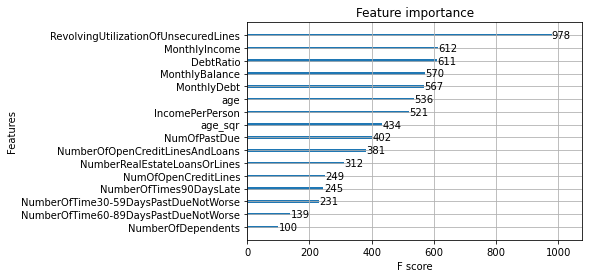

In [11]:
y_pred_train = final_model.predict(train)

xgb.plot_importance(final_model)
plt.show()

## Métricas de treino

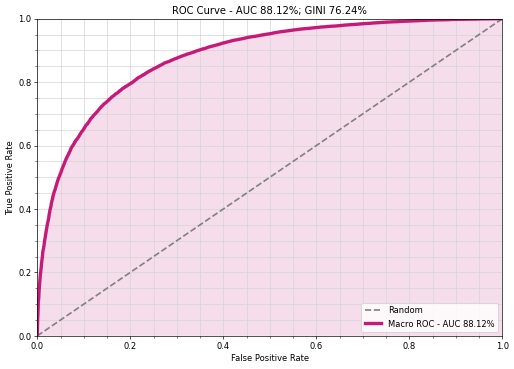

In [12]:
roc_auc_train = ROC_AUC(y_pred_train, y_train)
roc_auc_train.plot()

## Distribuição de scores de treino

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},


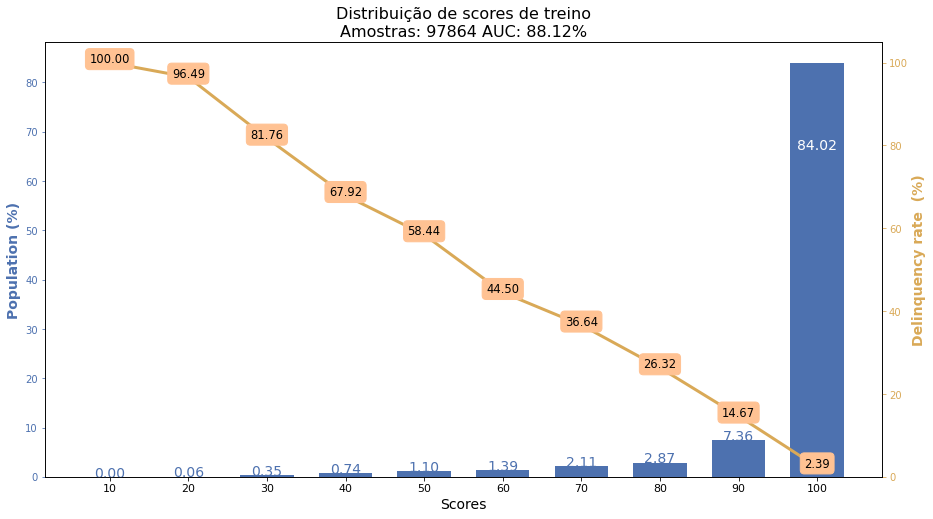

In [13]:
title_train = 'Distribuição de scores de treino\nAmostras: %d AUC: %.2f%%'\
    %(len(y_train), roc_auc_train.value*100)
ScoreDistribution(y_pred_train, y_train).plot(title=title_train)

## Métricas de teste

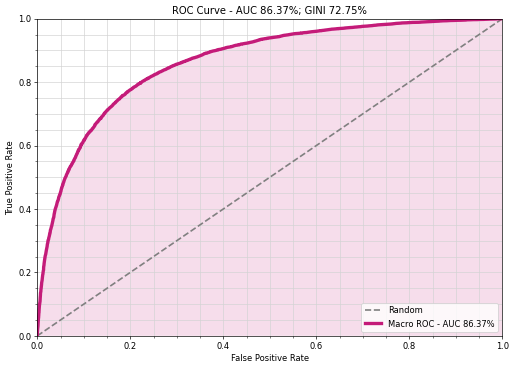

In [14]:
y_pred = final_model.predict(test)
roc_auc_test = ROC_AUC(y_pred, y_test)
roc_auc_test.plot()

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},


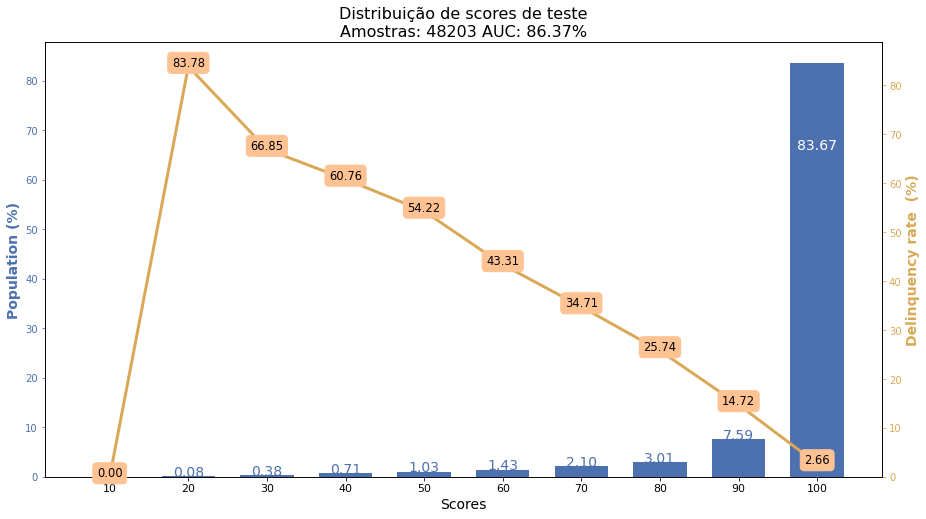

In [15]:
title_test = 'Distribuição de scores de teste\nAmostras: %d AUC: %.2f%%'%\
    (len(y_test), roc_auc_test.value*100)
ScoreDistribution(y_pred, y_test).plot(title=title_test)

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},
/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},


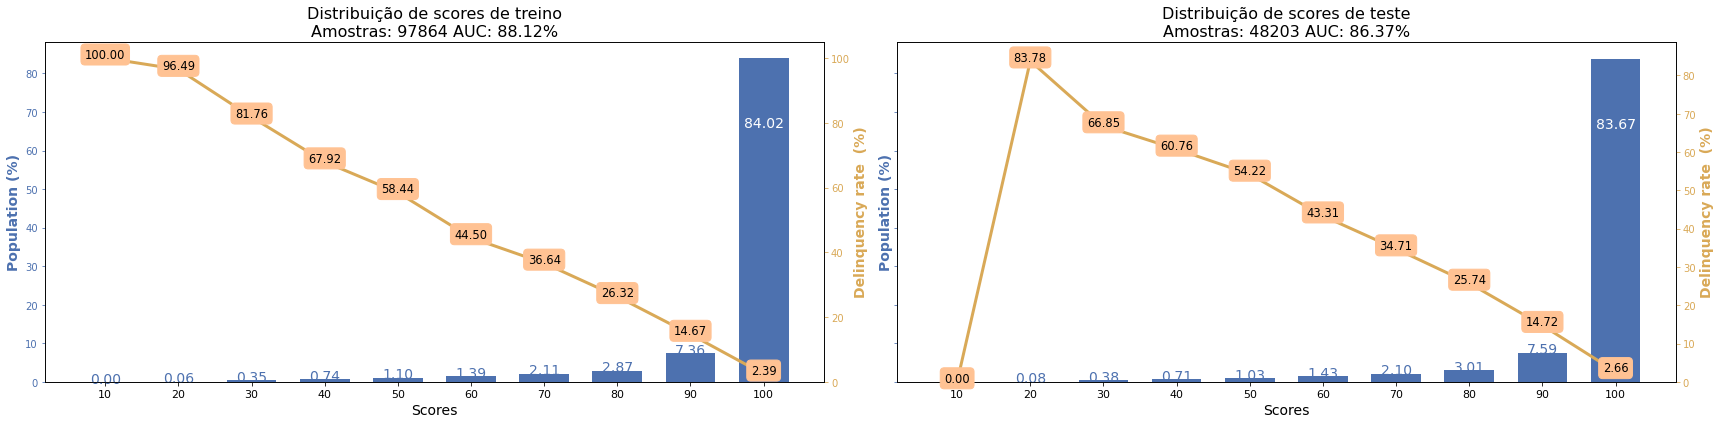

In [16]:
fig, axis = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
ScoreDistribution(y_pred_train, y_train).plot(ax=axis[0], title=title_train)
ScoreDistribution(y_pred, y_test).plot(ax=axis[1], title=title_test)
plt.tight_layout()
plt.show()

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},
/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},
/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:433: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ], {'size': fontsize - 2})


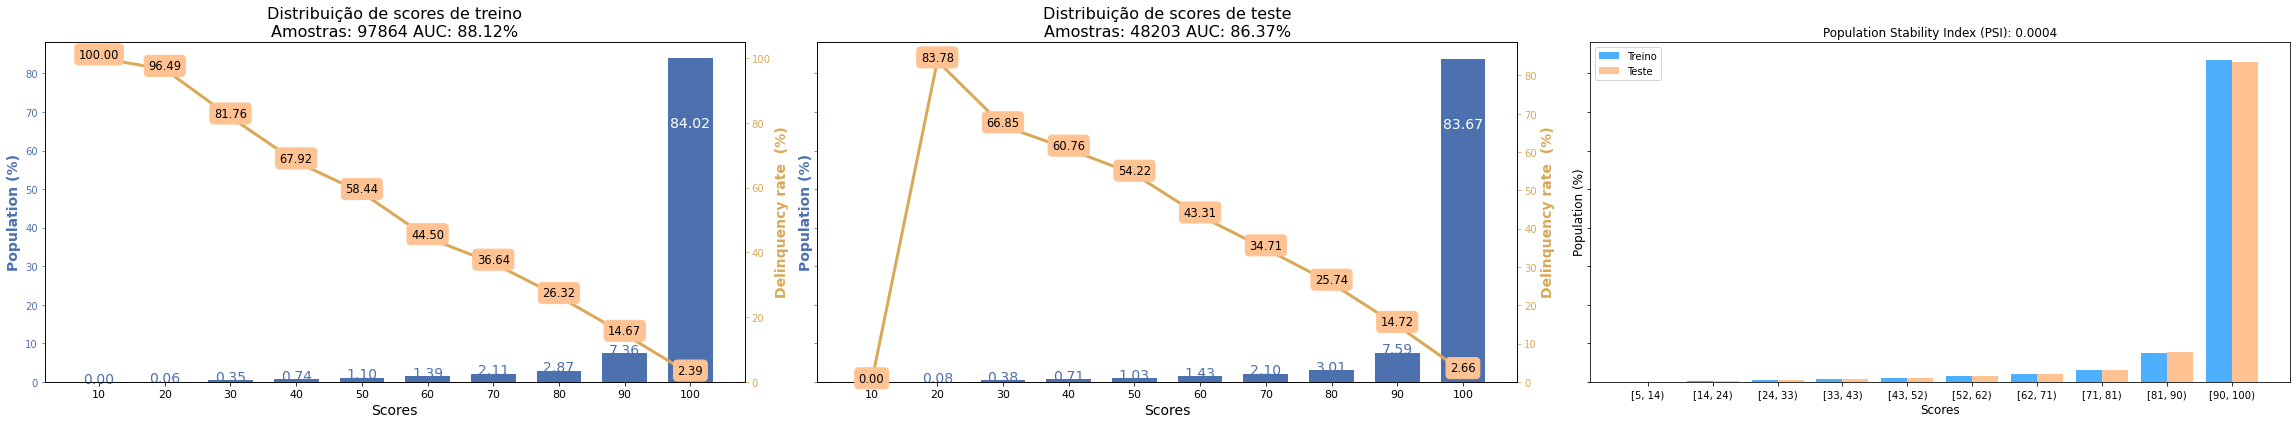

In [17]:
fig, axis = plt.subplots(1, 3, figsize=(32, 6), sharey=True)
ScoreDistribution(y_pred_train, y_train).plot(ax=axis[0], title=title_train)
ScoreDistribution(y_pred, y_test).plot(ax=axis[1], title=title_test)
PSI(y_pred_train, y_pred).plot('Treino', 'Teste', ax=axis[2])
plt.tight_layout()
plt.show()

# Balanceando a amostra de treino - undersampling

In [45]:
X_train_under, y_train_under = get_resampling(X_train, y_train, 
                                              verbose=False, 
                                              random_state=42, 
                                              by='undersampling', 
                                              good_mult=1)

In [46]:
y_train_under.value_counts(normalize=True)

1    0.5
0    0.5
Name: bom_pagador, dtype: float64

In [47]:
train = xgb.DMatrix(X_train_under,y_train_under,
                    feature_names=X_train_under.columns)
test = xgb.DMatrix(X_test,feature_names=X_train_under.columns)
xgb_params = {
                    'eta':0.03,
                    'max_depth':4,
                    'sub_sample':0.9,
                    'colsample_bytree':0.5,
                    'objective':'binary:logistic',
                    'eval_metric':'auc',
                    'silent':0
                    }

final_model_under = xgb.train(xgb_params,train,num_boost_round=500)

[18:14:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




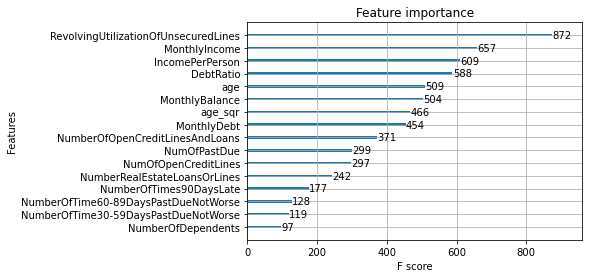

In [48]:
y_pred_train_under = final_model_under.predict(train)

xgb.plot_importance(final_model_under)
plt.show()

## Métricas de treino - Undersampling

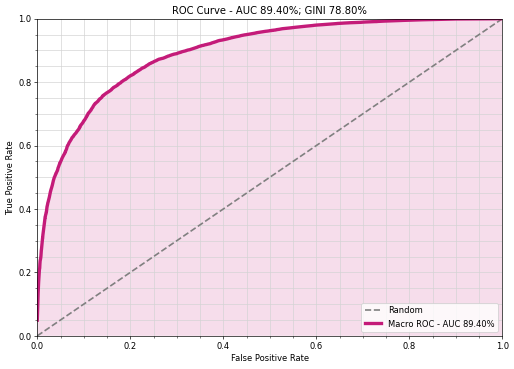

In [49]:
roc_auc_train_under = ROC_AUC(y_pred_train_under, y_train_under)
roc_auc_train_under.plot()

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},


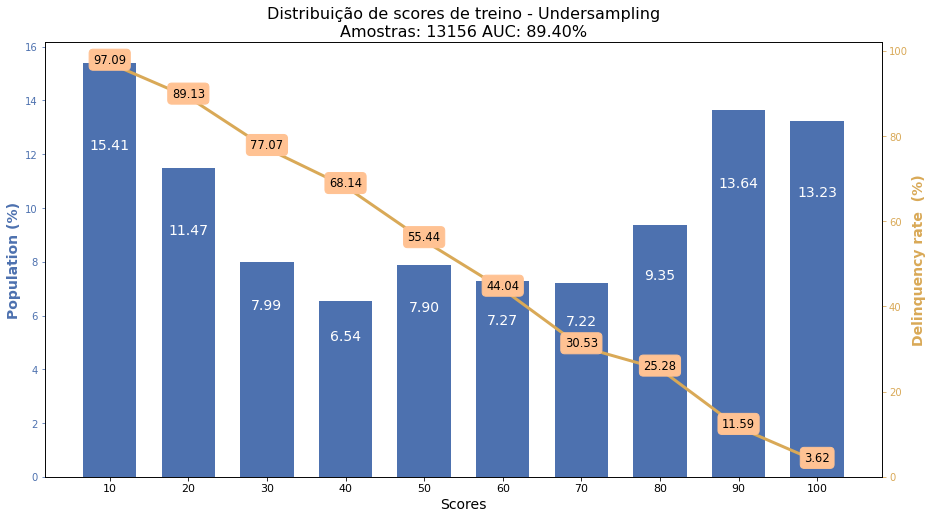

In [50]:
title_train_under = 'Distribuição de scores de treino - Undersampling\nAmostras: %d AUC: %.2f%%'%\
    (len(y_train_under), roc_auc_train_under.value*100)
ScoreDistribution(y_pred_train_under, y_train_under).plot(title=title_train_under)

## Métricas de teste - undersampling

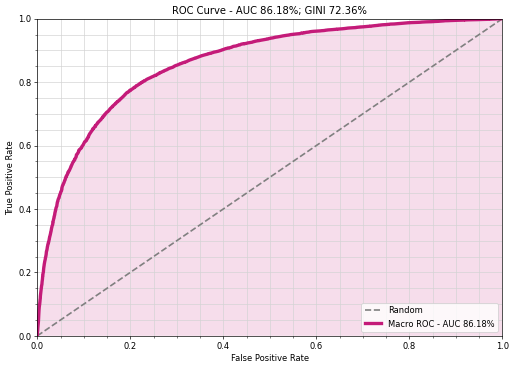

In [51]:
y_pred_under = final_model_under.predict(test)

roc_auc_test_under = ROC_AUC(y_pred_under, y_test)
roc_auc_test_under.plot()

In [53]:
X_test.head(2)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,IncomePerPerson,NumOfPastDue,MonthlyDebt,NumOfOpenCreditLines,MonthlyBalance,age_sqr
44144,0.064525,71,0,1591.000000,NaN,6,0,1,0,0.0,NaN,0,NaN,5,NaN,69
8267,0.170445,34,0,0.525246,8.699681,9,0,2,0,0.0,8.699681,0,4.569471,7,4.13021,32


In [54]:
y_pred_under[:2]

array([0.96418333, 0.7055743 ], dtype=float32)

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},


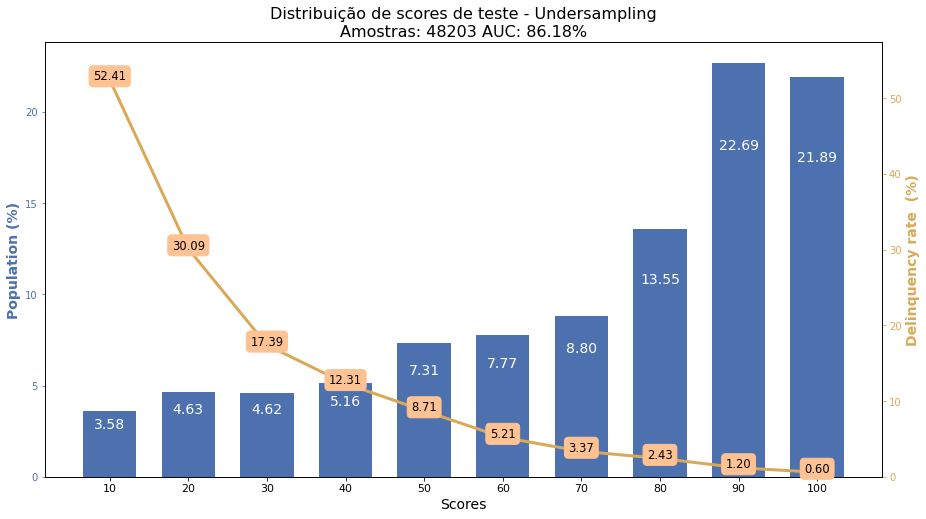

In [25]:
title_test_under = 'Distribuição de scores de teste - Undersampling\nAmostras: %d AUC: %.2f%%'%\
    (len(y_pred_under), roc_auc_test_under.value*100)
ScoreDistribution(y_pred_under, y_test).plot(title_test_under)


/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},
/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},
/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:433: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ], {'size': fontsize - 2})


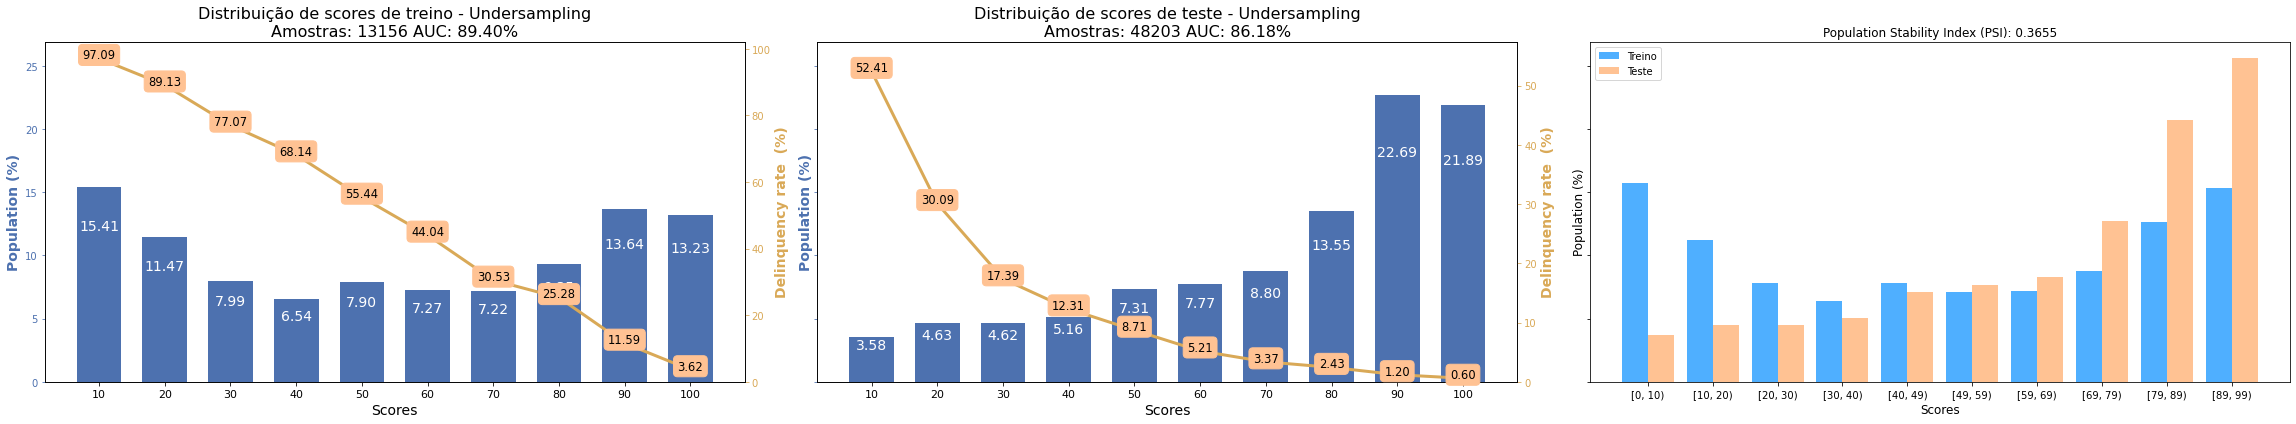

In [26]:
fig, axis = plt.subplots(1, 3, figsize=(32, 6), sharey=True)
ScoreDistribution(y_pred_train_under, y_train_under).plot(ax=axis[0],title=title_train_under)
ScoreDistribution(y_pred_under, y_test).plot(title_test_under, ax=axis[1])
PSI(y_pred_train_under, y_pred_under).plot('Treino', 'Teste', ax=axis[2])
plt.tight_layout()
plt.show()

## Buscando novos parâmetros

### A célula abaixo demorou 15 min em um i7 com 16GB de ram e sem GPU - 17:45:46

In [27]:
%%time
train_performance = xgbCV(eta=[0.01,0.02,0.03,0.04,0.05],
                          max_depth=[4,6,8,10],
                          colsample_bytree=[0.3,0.5,0.7,0.9],
                          train_X = X_train_under, 
                          train_y = y_train_under,
                          test_X = X_test)

[13:31:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parame

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.01, 4, 0.9, 0.3). Training performance is nan. Validation performance is 0.8611
[13:31:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.01, 4, 0.9, 0.5). Training performance is nan. Validation performance is 0.8617
[13:31:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:31:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.01, 4, 0.9, 0.7). Training performance is nan. Validation performance is 0.8632
[13:32:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.01, 4, 0.9, 0.9). Training performance is nan. Validation performance is 0.8615
[13:32:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.01, 6, 0.9, 0.3). Training performance is nan. Validation performance is 0.8612
[13:32:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.01, 6, 0.9, 0.5). Training performance is nan. Validation performance is 0.8622
[13:32:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.01, 6, 0.9, 0.7). Training performance is nan. Validation performance is 0.8624
[13:32:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.01, 6, 0.9, 0.9). Training performance is nan. Validation performance is 0.8613
[13:32:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.01, 8, 0.9, 0.3). Training performance is nan. Validation performance is 0.8593
[13:32:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.01, 8, 0.9, 0.5). Training performance is nan. Validation performance is 0.8620
[13:32:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:32:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.01, 8, 0.9, 0.7). Training performance is nan. Validation performance is 0.8603
[13:33:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:33:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:33:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.01, 8, 0.9, 0.9). Training performance is nan. Validation performance is 0.8569
[13:33:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:33:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:33:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.01, 10, 0.9, 0.3). Training performance is nan. Validation performance is 0.8578
[13:33:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:33:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:33:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.01, 10, 0.9, 0.5). Training performance is nan. Validation performance is 0.8601
[13:33:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:33:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:33:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.01, 10, 0.9, 0.7). Training performance is nan. Validation performance is 0.8576
[13:33:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:33:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:33:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.01, 10, 0.9, 0.9). Training performance is nan. Validation performance is 0.8532
[13:33:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:33:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:33:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.02, 4, 0.9, 0.3). Training performance is nan. Validation performance is 0.8641
[13:34:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.02, 4, 0.9, 0.5). Training performance is nan. Validation performance is 0.8644
[13:34:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.02, 4, 0.9, 0.7). Training performance is nan. Validation performance is 0.8645
[13:34:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.02, 4, 0.9, 0.9). Training performance is nan. Validation performance is 0.8642
[13:34:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.02, 6, 0.9, 0.3). Training performance is nan. Validation performance is 0.8623
[13:34:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.02, 6, 0.9, 0.5). Training performance is nan. Validation performance is 0.8632
[13:34:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.02, 6, 0.9, 0.7). Training performance is nan. Validation performance is 0.8630
[13:34:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.02, 6, 0.9, 0.9). Training performance is nan. Validation performance is 0.8616
[13:35:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:35:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:35:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.02, 8, 0.9, 0.3). Training performance is nan. Validation performance is 0.8605
[13:35:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:35:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:35:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.02, 8, 0.9, 0.5). Training performance is nan. Validation performance is 0.8615
[13:35:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:35:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:35:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.02, 8, 0.9, 0.7). Training performance is nan. Validation performance is 0.8604
[13:35:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:35:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:35:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.02, 8, 0.9, 0.9). Training performance is nan. Validation performance is 0.8585
[13:35:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:35:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:35:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.02, 10, 0.9, 0.3). Training performance is nan. Validation performance is 0.8583
[13:35:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:35:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:35:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.02, 10, 0.9, 0.5). Training performance is nan. Validation performance is 0.8598
[13:36:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:36:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:36:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.02, 10, 0.9, 0.7). Training performance is nan. Validation performance is 0.8576
[13:36:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:36:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:36:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.02, 10, 0.9, 0.9). Training performance is nan. Validation performance is 0.8540
[13:36:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:36:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:36:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.03, 4, 0.9, 0.3). Training performance is nan. Validation performance is 0.8645
[13:36:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:36:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:36:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.03, 4, 0.9, 0.5). Training performance is nan. Validation performance is 0.8651
[13:36:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:36:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:36:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.03, 4, 0.9, 0.7). Training performance is nan. Validation performance is 0.8648
[13:36:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:36:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:36:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.03, 4, 0.9, 0.9). Training performance is nan. Validation performance is 0.8642
[13:36:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:36:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:36:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.03, 6, 0.9, 0.3). Training performance is nan. Validation performance is 0.8629
[13:37:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.03, 6, 0.9, 0.5). Training performance is nan. Validation performance is 0.8637
[13:37:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.03, 6, 0.9, 0.7). Training performance is nan. Validation performance is 0.8632
[13:37:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.03, 6, 0.9, 0.9). Training performance is nan. Validation performance is 0.8628
[13:37:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:29] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.03, 8, 0.9, 0.3). Training performance is nan. Validation performance is 0.8603
[13:37:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.03, 8, 0.9, 0.5). Training performance is nan. Validation performance is 0.8616
[13:37:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.03, 8, 0.9, 0.7). Training performance is nan. Validation performance is 0.8606
[13:37:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.03, 8, 0.9, 0.9). Training performance is nan. Validation performance is 0.8578
[13:37:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.03, 10, 0.9, 0.3). Training performance is nan. Validation performance is 0.8581
[13:38:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.03, 10, 0.9, 0.5). Training performance is nan. Validation performance is 0.8594
[13:38:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.03, 10, 0.9, 0.7). Training performance is nan. Validation performance is 0.8581
[13:38:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.03, 10, 0.9, 0.9). Training performance is nan. Validation performance is 0.8551
[13:38:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.04, 4, 0.9, 0.3). Training performance is nan. Validation performance is 0.8645
[13:38:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.04, 4, 0.9, 0.5). Training performance is nan. Validation performance is 0.8653
[13:38:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:52] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.04, 4, 0.9, 0.7). Training performance is nan. Validation performance is 0.8649
[13:38:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:38:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.04, 4, 0.9, 0.9). Training performance is nan. Validation performance is 0.8644
[13:39:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:06] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.04, 6, 0.9, 0.3). Training performance is nan. Validation performance is 0.8625
[13:39:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.04, 6, 0.9, 0.5). Training performance is nan. Validation performance is 0.8642
[13:39:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.04, 6, 0.9, 0.7). Training performance is nan. Validation performance is 0.8635
[13:39:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.04, 6, 0.9, 0.9). Training performance is nan. Validation performance is 0.8627
[13:39:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:35] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.04, 8, 0.9, 0.3). Training performance is nan. Validation performance is 0.8606
[13:39:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.04, 8, 0.9, 0.5). Training performance is nan. Validation performance is 0.8612
[13:39:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.04, 8, 0.9, 0.7). Training performance is nan. Validation performance is 0.8602
[13:39:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:39:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.04, 8, 0.9, 0.9). Training performance is nan. Validation performance is 0.8588
[13:40:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.04, 10, 0.9, 0.3). Training performance is nan. Validation performance is 0.8581
[13:40:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.04, 10, 0.9, 0.5). Training performance is nan. Validation performance is 0.8589
[13:40:20] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.04, 10, 0.9, 0.7). Training performance is nan. Validation performance is 0.8576
[13:40:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.04, 10, 0.9, 0.9). Training performance is nan. Validation performance is 0.8544
[13:40:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.05, 4, 0.9, 0.3). Training performance is nan. Validation performance is 0.8648
[13:40:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:44] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.05, 4, 0.9, 0.5). Training performance is nan. Validation performance is 0.8648
[13:40:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.05, 4, 0.9, 0.7). Training performance is nan. Validation performance is 0.8648
[13:40:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.05, 4, 0.9, 0.9). Training performance is nan. Validation performance is 0.8643
[13:41:02] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.05, 6, 0.9, 0.3). Training performance is nan. Validation performance is 0.8629
[13:41:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.05, 6, 0.9, 0.5). Training performance is nan. Validation performance is 0.8639
[13:41:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:14] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.05, 6, 0.9, 0.7). Training performance is nan. Validation performance is 0.8634
[13:41:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:19] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.05, 6, 0.9, 0.9). Training performance is nan. Validation performance is 0.8628
[13:41:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.05, 8, 0.9, 0.3). Training performance is nan. Validation performance is 0.8605
[13:41:31] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:33] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.05, 8, 0.9, 0.5). Training performance is nan. Validation performance is 0.8616
[13:41:38] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.05, 8, 0.9, 0.7). Training performance is nan. Validation performance is 0.8600
[13:41:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:47] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.05, 8, 0.9, 0.9). Training performance is nan. Validation performance is 0.8584
[13:41:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:41:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to som

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.05, 10, 0.9, 0.3). Training performance is nan. Validation performance is 0.8586
[13:42:01] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:42:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:42:04] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.05, 10, 0.9, 0.5). Training performance is nan. Validation performance is 0.8583
[13:42:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:42:09] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:42:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Parameters are (0.05, 10, 0.9, 0.7). Training performance is nan. Validation performance is 0.8574
[13:42:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:42:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:42:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to so

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:91: RuntimeWarning: Mean of empty slice.
  train_mean = (np.asarray(training_score).astype(np.float).mean()) # mean AUC in training set
/Users/marciopalheta/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Treino com novos parâmetros

In [28]:
train = xgb.DMatrix(X_train_under,y_train_under,feature_names=X_train_under.columns)
test = xgb.DMatrix(X_test,feature_names=X_train_under.columns)
xgb_params = {
                    'eta':0.04,
                    'max_depth':4,
                    'sub_sample':0.9,
                    'colsample_bytree':0.5,
                    'objective':'binary:logistic',
                    'eval_metric':'auc',
                    'silent':0
                    }

final_model_under = xgb.train(xgb_params,train,num_boost_round=500)

[13:42:25] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { silent, sub_sample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [40]:
X_test.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,IncomePerPerson,NumOfPastDue,MonthlyDebt,NumOfOpenCreditLines,MonthlyBalance,age_sqr
44144,0.064525,71,0,1591.000000,NaN,6,0,1,0,0.000000,NaN,0,NaN,5,NaN,69
8267,0.170445,34,0,0.525246,8.699681,9,0,2,0,0.000000,8.699681,0,4.569471,7,4.130210,32
109867,0.836445,30,0,0.318560,8.006701,7,0,0,0,0.693147,4.728887,0,2.550618,7,5.456082,28
131268,0.064711,67,0,0.330114,8.996652,16,0,2,0,0.000000,8.996652,0,2.969920,14,6.026732,65
106336,0.533032,41,0,0.495105,8.558143,12,0,2,0,0.000000,8.558143,0,4.237176,10,4.320967,43


In [39]:
X_train_under.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'IncomePerPerson', 'NumOfPastDue', 'MonthlyDebt',
       'NumOfOpenCreditLines', 'MonthlyBalance', 'age_sqr'],
      dtype='object')

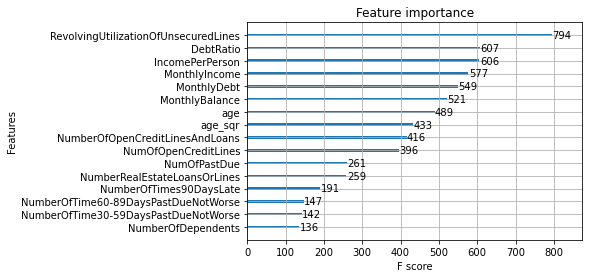

In [29]:
y_pred_train_under = final_model_under.predict(train)

xgb.plot_importance(final_model_under)
plt.show()

## Métricas de treino - Undersampling

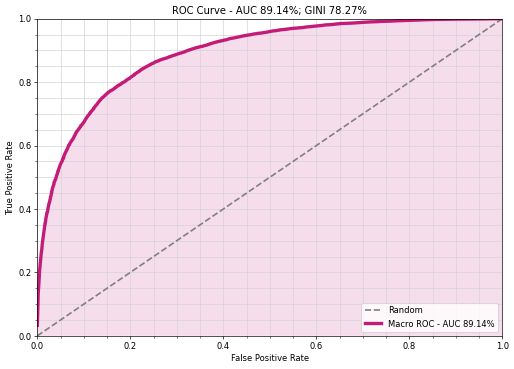

In [30]:
roc_auc_train_under = ROC_AUC(y_pred_train_under, y_train_under)
roc_auc_train_under.plot()

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},


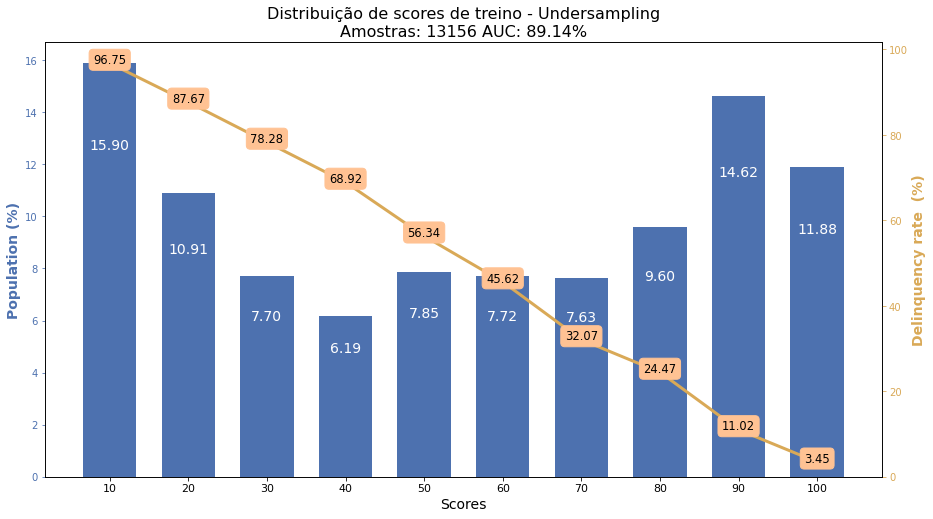

In [31]:
title_train_under = 'Distribuição de scores de treino - Undersampling\nAmostras: %d AUC: %.2f%%'%(len(y_train_under), roc_auc_train_under.value*100)
ScoreDistribution(y_pred_train_under, y_train_under).plot(title=title_train_under)


## Métricas de teste - undersampling

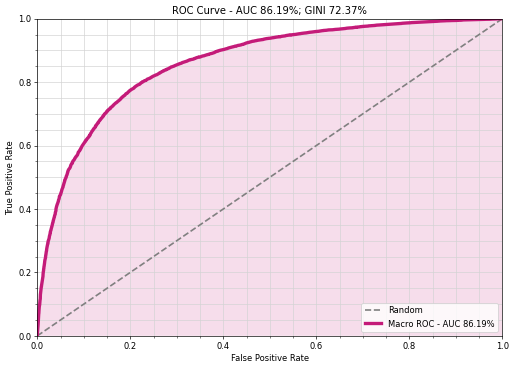

In [32]:
y_pred_under = final_model_under.predict(test)

roc_auc_test_under = ROC_AUC(y_pred_under, y_test)
roc_auc_test_under.plot()

In [42]:
y_pred_under[:5]

array([0.9664374 , 0.69689476, 0.38769156, 0.8650759 , 0.52005386],
      dtype=float32)

In [43]:
X_test[:5]

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,IncomePerPerson,NumOfPastDue,MonthlyDebt,NumOfOpenCreditLines,MonthlyBalance,age_sqr
44144,0.064525,71,0,1591.000000,NaN,6,0,1,0,0.000000,NaN,0,NaN,5,NaN,69
8267,0.170445,34,0,0.525246,8.699681,9,0,2,0,0.000000,8.699681,0,4.569471,7,4.130210,32
109867,0.836445,30,0,0.318560,8.006701,7,0,0,0,0.693147,4.728887,0,2.550618,7,5.456082,28
131268,0.064711,67,0,0.330114,8.996652,16,0,2,0,0.000000,8.996652,0,2.969920,14,6.026732,65
106336,0.533032,41,0,0.495105,8.558143,12,0,2,0,0.000000,8.558143,0,4.237176,10,4.320967,43


In [44]:
X_test.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'IncomePerPerson', 'NumOfPastDue', 'MonthlyDebt',
       'NumOfOpenCreditLines', 'MonthlyBalance', 'age_sqr'],
      dtype='object')

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},


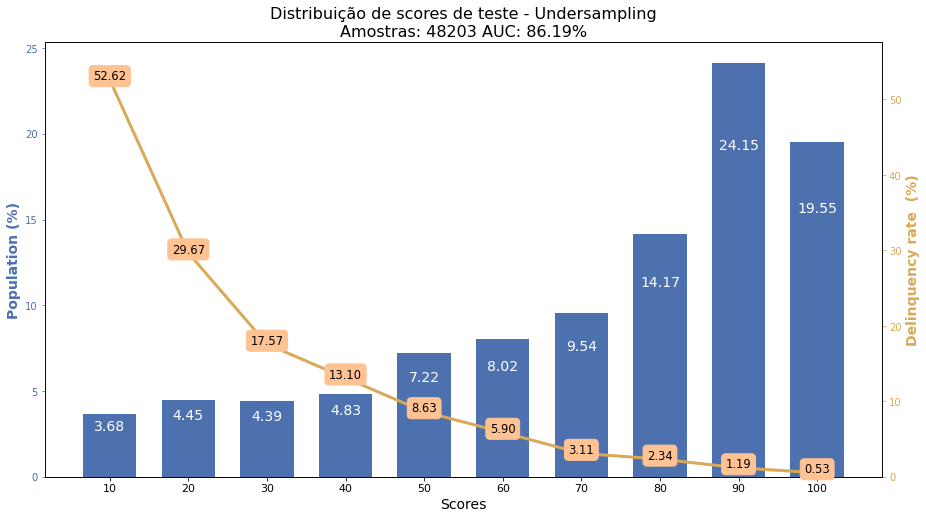

In [33]:
title_test_under = 'Distribuição de scores de teste - Undersampling\nAmostras: %d AUC: %.2f%%'%(len(y_pred_under), roc_auc_test_under.value*100)
ScoreDistribution(y_pred_under, y_test).plot(title_test_under)


/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},
/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},
/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:433: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  ], {'size': fontsize - 2})


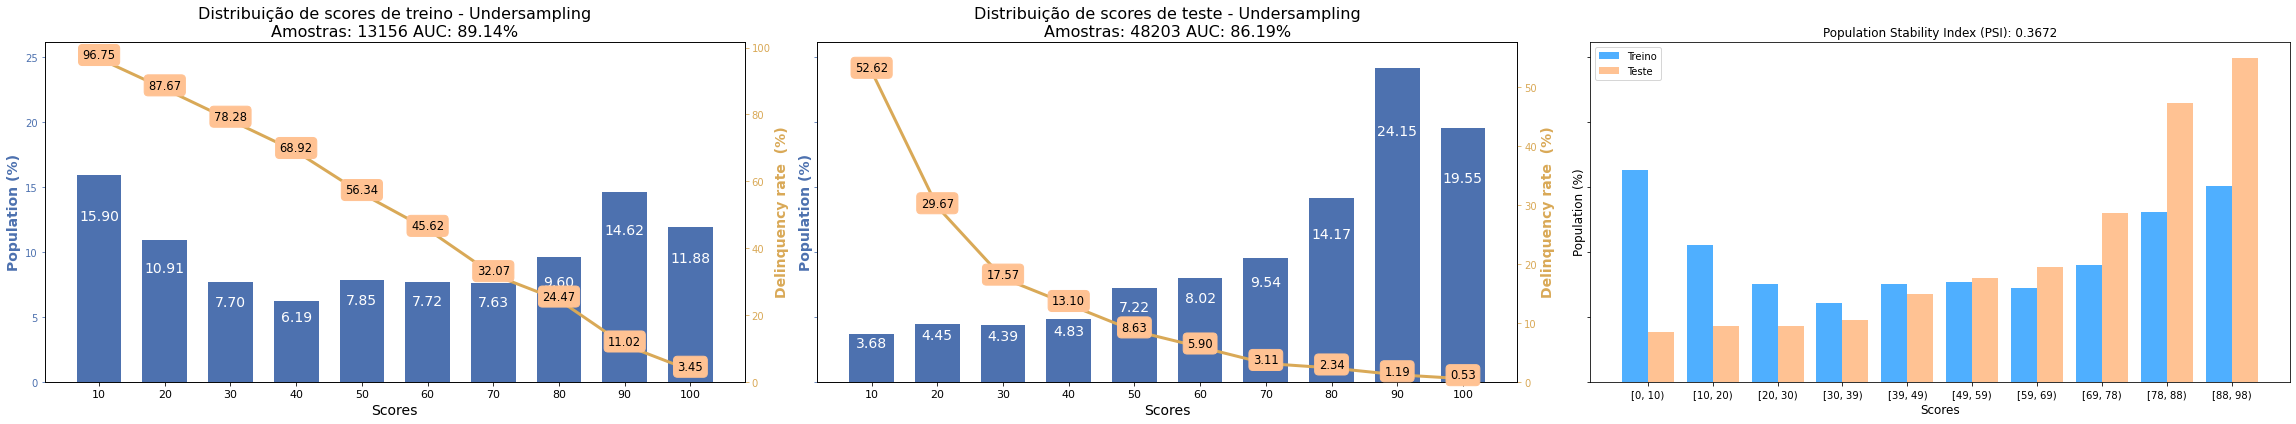

In [34]:
fig, axis = plt.subplots(1, 3, figsize=(32, 6), sharey=True)
ScoreDistribution(y_pred_train_under, y_train_under).plot(ax=axis[0],title=title_train_under)
ScoreDistribution(y_pred_under, y_test).plot(title_test_under, ax=axis[1])
PSI(y_pred_train_under, y_pred_under).plot('Treino', 'Teste', ax=axis[2])
plt.tight_layout()
plt.show()

## Comparando modelos

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},
/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},


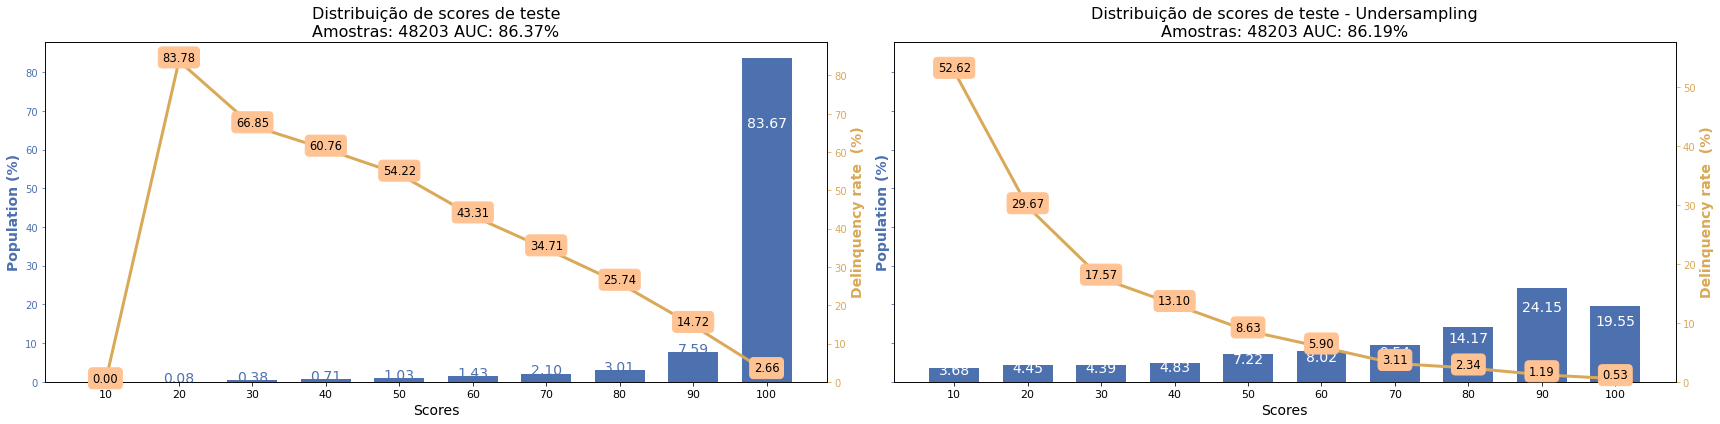

In [35]:
fig, axis = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
ScoreDistribution(y_pred, y_test).plot(ax=axis[0], title=title_test)
ScoreDistribution(y_pred_under, y_test).plot(title_test_under, ax=axis[1])
plt.tight_layout()
plt.show()

/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},
/Users/marciopalheta/Documents/uea/CienciaDeDadosParaNegocios/notebooks/util.py:1059: MatplotlibDeprecationWarning: Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  {"size": fontsize - 3},


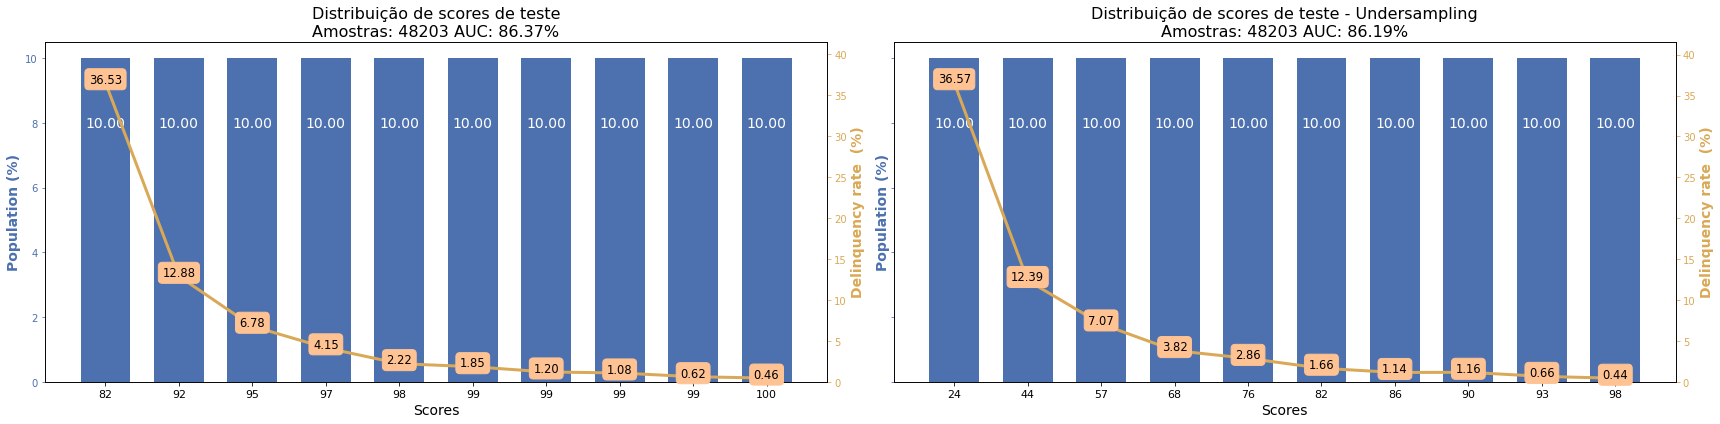

In [36]:
fig, axis = plt.subplots(1, 2, figsize=(24, 6), sharey=True)
ScoreDistribution(y_pred, y_test, buckets_as_quantiles=True).plot(ax=axis[0], title=title_test)
ScoreDistribution(y_pred_under, y_test, buckets_as_quantiles=True).plot(title_test_under, ax=axis[1])
plt.tight_layout()
plt.show()

# Meu modelo está pronto. E agora ?

- Transformar um sistem em um produto passa pela cultura DEVOPS

In [55]:
# save
file_name = 'xgboost_undersampling.pkl'
pickle.dump(final_model_under, open(file_name, "wb"))

In [38]:
# load
file_name = 'xgboost_undersampling.pkl'
xgb_model_loaded = pickle.load(open(file_name, "rb"))